In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.insert(0, "../src/")

In [7]:
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import xrscipy.signal as dsp
import gsw

from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter("ignore")

# set up figure params
sns.set(style='ticks', context='poster')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [8]:
from niwtools.tools import *
from niwtools.qc import qc_turbulence, qc_velocity
# from niwtools.niwtools.qc import qc_turbulence, qc_velocity

In [185]:
# events = {'A':{'floatids':['7779a','7781a','7783a','7786a','7787a','7788a'],'times':['2016-08-28','2016-09-04']},
#          'C': {'floatids':['7781a','7786a','7788a'],'times':['2016-10-02','2016-10-11']},
#          'D': {'floatids':['7779a','7781a','7786a','7788a'],'times':['2016-10-17','2016-11-03']},
#          'E': {'floatids':['7779a','7787a'],'times':['2016-10-27','2016-11-05']}
#          }

# with open('events.yml','w') as fp:
#     yaml.dump(events,fp)

In [193]:
with open('events.yml') as fp:
    events = yaml.full_load(fp)

In [196]:
event='A'
collecter=[]
for floatid in events[event]['floatids']:

    raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
    cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
    cfs = cfs.sel(floatid=f'{floatid}')
    raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1)
    raw = raw.sel(time=slice(*events[event]['times']))

    raw = add_cfs_data(raw, floatid)
    f = gsw.f(40.7)/(2*np.pi)
    raw = bandpass_velocity(raw, 0.75*f, 1.25*f)
    raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
    mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)
    rho0=raw.rho0.mean()
    raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2) # that gonna be in [J m^{-3}]
    raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)
    raw['hkeNI_ml'] = raw.hkeNI.where(raw.z > raw.mld).mean(dim='z')
    raw['floatid'] = floatid
    collecter.append(raw)
    raw=[]
    
ds = xr.concat(collecter,dim='floatid')

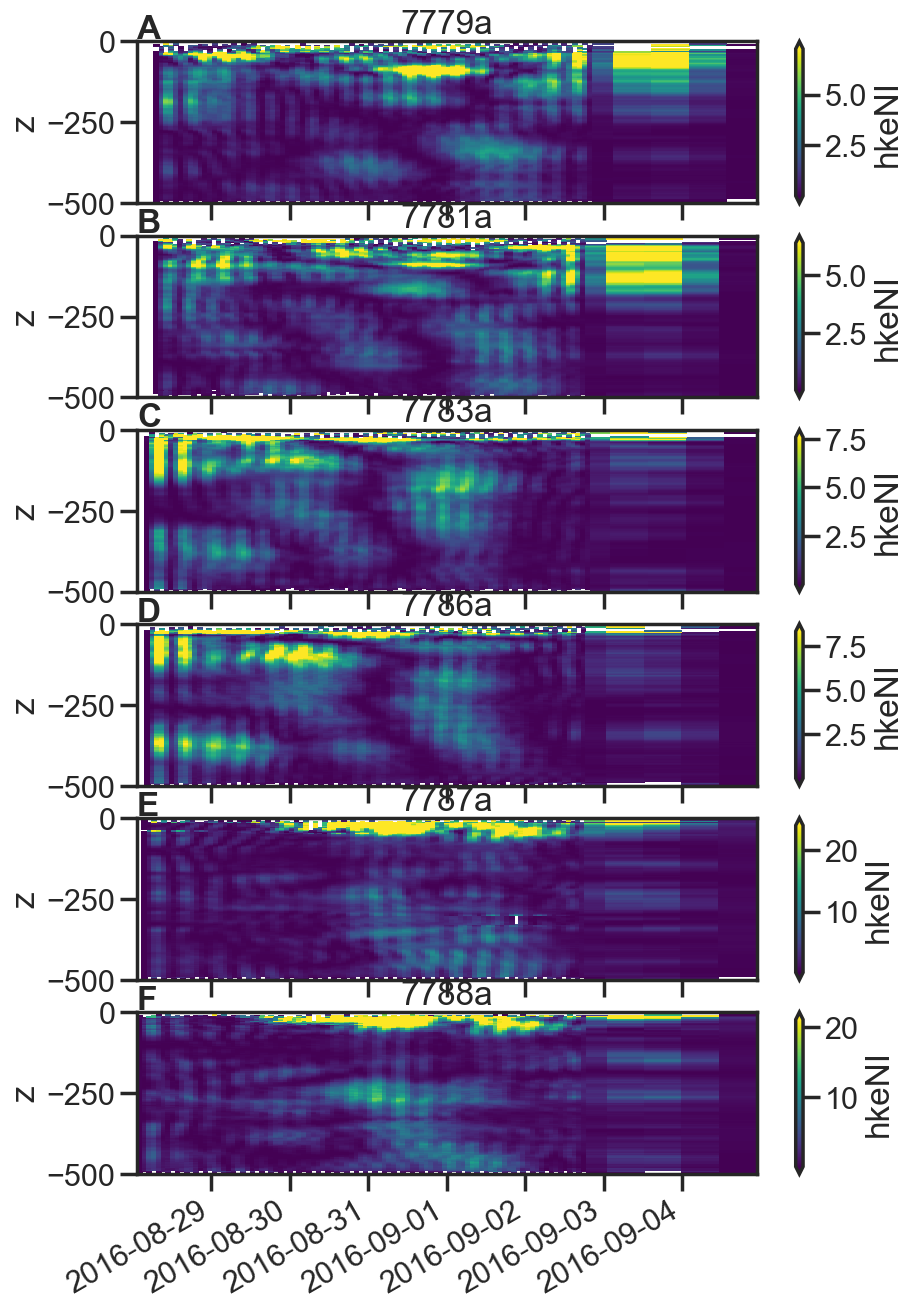

In [197]:
f,ax = plt.subplots(ds.floatid.size,1,figsize=(10,15), sharex=True)
for floatid in range(0,ds.floatid.size):
    ds.hkeNI.isel(floatid=floatid).dropna('z',how='all').dropna('time',how='all').plot(robust=True,
                                                                                        ax=ax[floatid], rasterized=True)
    ax[floatid].set_xlabel(None)
    ax[floatid].set_title(f'{ds.isel(floatid=floatid).floatid.values}')
    ax[floatid].set_ylim(-500,0)
alphabet(ax)

f.savefig(f'../figures/events/event_{event}_nihke.pdf')